### TFG - Cesar Hernandez Rodriguez
Segundos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores y no tendencias

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice nasdaq que es uno de los índices más importantes de Estados Unidos, siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. 

El primer paso será mediante WEB-Scrapping descargar de Wikipedia los tickets de los 500 valores del índice bursatil, después ire recursivamente descargando todos los datos disponibles de los 500 valores desde el 2000 hasta el final del año 2017, estos datos los usare para entrenar la red neuronal y poder predecir el primer trimestre de 2018. La selección de estas fechas se debe al a disponibilidad que ofrece la librería Quandl ya que al usarla de forma gratuita no se puede descargar los históricos de todos los datos ni todo los datos más actuales, de todas formas aún asi vamos a tener problemas ya que solo he conseguido de 485 de 500 activos y de algunos no tenemos unos datos históricos tan extensos como lo que buscabamos.

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

Using TensorFlow backend.


In [2]:
#Tengo dos bases de datos con todos los tickers del indice nasdaq y todos los tickers
# que tiene mi base de datos y extraigo solo los que tengo
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    tickers = random.choices(tickers, k=15)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2010-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  13.333333333333334 % de los datos
LLeva descargados el  26.666666666666668 % de los datos
LLeva descargados el  40.0 % de los datos
LLeva descargados el  53.333333333333336 % de los datos
LLeva descargados el  66.66666666666666 % de los datos
LLeva descargados el  80.0 % de los datos
LLeva descargados el  93.33333333333333 % de los datos

Ha tardado en descargar los datos: 26.0609960556 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  13.333333333333334 % de los datos test
LLeva descargados el  26.666666666666668 % de los datos test
LLeva descargados el  40.0 % de los datos test
LLeva descargados el  53.333333333333336 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test
LLeva descargados el  80.0 % de los datos test
LLeva descargados el  93.33333333333333 % de los datos test

Ha 

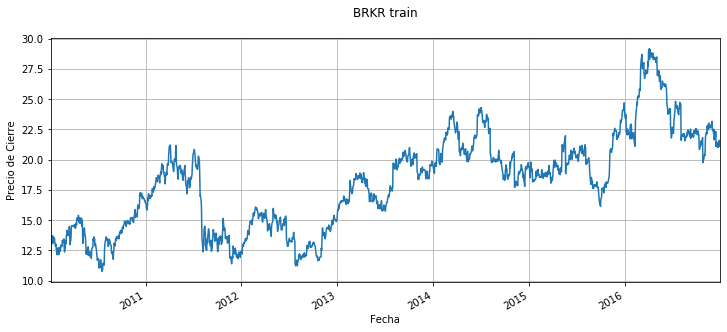

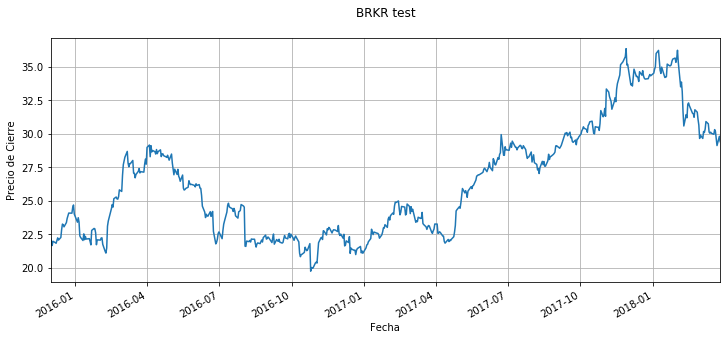

In [6]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [7]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],10,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo ",ticket_uso)

Voy a predecir el activo  BRKR


In [11]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [12]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model.add(LSTM(units = 5,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 252, 10)           560       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 992 samples, validate on 497 samples
Epoch 1/1500
992/992 [==============================] - 15s 15ms/step - loss: 345.6437 - porcentaje_margen: 0.0000e+00 - val_loss: 320.3761 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
992/992 [==============================] - 12s 13ms/step - loss: 312.2354 - porcentaje_margen: 0.0000e+00 - val_loss: 294.6915 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
992/992 [==============================] - 13s 13ms/step - loss: 291.8982 - porcentaje_margen: 0.0000e+00 - val_loss: 277.7680 - val_porcentaje_margen: 0.0000e+00
Epoch 4/1500
992/992 [==============================] - 13s 13ms/step - loss: 275.7254 - porcentaje_margen: 0.0000e+00 - val_loss: 262.8010 - val_porcentaje_margen: 0.0000e+00
Epoch 5/1500
992/992 [==============================] - 12s 12ms/step - loss: 262.0158 - porcentaje_margen: 0.0000e+00 - val_loss: 250.9947 - val_porcentaje_margen: 0.0000e+00
Epoch 6/1500
992/992 [==============================] - 13s 13ms/step - lo

992/992 [==============================] - 12s 12ms/step - loss: 82.2321 - porcentaje_margen: 0.0000e+00 - val_loss: 79.1471 - val_porcentaje_margen: 0.0059
Epoch 48/1500
992/992 [==============================] - 12s 12ms/step - loss: 79.9237 - porcentaje_margen: 0.0010 - val_loss: 76.9625 - val_porcentaje_margen: 0.0095
Epoch 49/1500
992/992 [==============================] - 12s 12ms/step - loss: 77.6897 - porcentaje_margen: 0.0030 - val_loss: 74.8219 - val_porcentaje_margen: 0.0095
Epoch 50/1500
992/992 [==============================] - 12s 12ms/step - loss: 75.5119 - porcentaje_margen: 0.0040 - val_loss: 72.7254 - val_porcentaje_margen: 0.0115
Epoch 51/1500
992/992 [==============================] - 12s 12ms/step - loss: 73.3813 - porcentaje_margen: 0.0091 - val_loss: 70.6966 - val_porcentaje_margen: 0.0173
Epoch 52/1500
992/992 [==============================] - 12s 12ms/step - loss: 71.3145 - porcentaje_margen: 0.0161 - val_loss: 68.7069 - val_porcentaje_margen: 0.0288
Epoch 53

992/992 [==============================] - 12s 12ms/step - loss: 21.5888 - porcentaje_margen: 0.0716 - val_loss: 21.9196 - val_porcentaje_margen: 0.0759
Epoch 97/1500
992/992 [==============================] - 12s 12ms/step - loss: 21.1433 - porcentaje_margen: 0.0736 - val_loss: 21.5200 - val_porcentaje_margen: 0.0759
Epoch 98/1500
992/992 [==============================] - 12s 12ms/step - loss: 20.7171 - porcentaje_margen: 0.0756 - val_loss: 21.1397 - val_porcentaje_margen: 0.0720
Epoch 99/1500
992/992 [==============================] - 12s 12ms/step - loss: 20.3098 - porcentaje_margen: 0.0786 - val_loss: 20.7801 - val_porcentaje_margen: 0.0759
Epoch 100/1500
992/992 [==============================] - 12s 12ms/step - loss: 19.9204 - porcentaje_margen: 0.0806 - val_loss: 20.4439 - val_porcentaje_margen: 0.0798
Epoch 101/1500
992/992 [==============================] - 12s 12ms/step - loss: 19.5591 - porcentaje_margen: 0.0796 - val_loss: 20.1014 - val_porcentaje_margen: 0.0818
Epoch 102/

Epoch 145/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.9189 - porcentaje_margen: 0.2399 - val_loss: 15.5412 - val_porcentaje_margen: 0.2256
Epoch 146/1500
992/992 [==============================] - 11s 12ms/step - loss: 13.9058 - porcentaje_margen: 0.2399 - val_loss: 15.5369 - val_porcentaje_margen: 0.2276
Epoch 147/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.8939 - porcentaje_margen: 0.2440 - val_loss: 15.5333 - val_porcentaje_margen: 0.2276
Epoch 148/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.8824 - porcentaje_margen: 0.2450 - val_loss: 15.5305 - val_porcentaje_margen: 0.2237
Epoch 149/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.8722 - porcentaje_margen: 0.2440 - val_loss: 15.5287 - val_porcentaje_margen: 0.2217
Epoch 150/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.8626 - porcentaje_margen: 0.2450 - val_loss: 15.5277 - val_porcentaje_margen:

Epoch 194/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7970 - porcentaje_margen: 0.2772 - val_loss: 15.5716 - val_porcentaje_margen: 0.2474
Epoch 195/1500
992/992 [==============================] - 10s 11ms/step - loss: 13.7962 - porcentaje_margen: 0.2772 - val_loss: 15.5750 - val_porcentaje_margen: 0.2474
Epoch 196/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7970 - porcentaje_margen: 0.2772 - val_loss: 15.5754 - val_porcentaje_margen: 0.2474
Epoch 197/1500
992/992 [==============================] - 10s 11ms/step - loss: 13.7962 - porcentaje_margen: 0.2772 - val_loss: 15.5743 - val_porcentaje_margen: 0.2474
Epoch 198/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7963 - porcentaje_margen: 0.2772 - val_loss: 15.5744 - val_porcentaje_margen: 0.2474
Epoch 199/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7970 - porcentaje_margen: 0.2772 - val_loss: 15.5738 - val_porcentaje_margen:

Epoch 243/1500
992/992 [==============================] - 10s 11ms/step - loss: 13.7971 - porcentaje_margen: 0.2772 - val_loss: 15.5727 - val_porcentaje_margen: 0.2474
Epoch 244/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7982 - porcentaje_margen: 0.2772 - val_loss: 15.5798 - val_porcentaje_margen: 0.2474
Epoch 245/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7975 - porcentaje_margen: 0.2772 - val_loss: 15.5737 - val_porcentaje_margen: 0.2474
Epoch 246/1500
992/992 [==============================] - 10s 10ms/step - loss: 13.7972 - porcentaje_margen: 0.2772 - val_loss: 15.5798 - val_porcentaje_margen: 0.2474
Epoch 247/1500
992/992 [==============================] - 11s 11ms/step - loss: 13.7967 - porcentaje_margen: 0.2772 - val_loss: 15.5776 - val_porcentaje_margen: 0.2454
Epoch 248/1500
992/992 [==============================] - 10s 11ms/step - loss: 13.7990 - porcentaje_margen: 0.2782 - val_loss: 15.5809 - val_porcentaje_margen:

992/992 [==============================] - 11s 11ms/step - loss: 1.4808 - porcentaje_margen: 0.7470 - val_loss: 1.7573 - val_porcentaje_margen: 0.7116
Epoch 293/1500
992/992 [==============================] - 10s 11ms/step - loss: 1.4611 - porcentaje_margen: 0.7490 - val_loss: 1.6886 - val_porcentaje_margen: 0.7348
Epoch 294/1500
992/992 [==============================] - 10s 10ms/step - loss: 1.4356 - porcentaje_margen: 0.7520 - val_loss: 1.6462 - val_porcentaje_margen: 0.7407
Epoch 295/1500
992/992 [==============================] - 10s 10ms/step - loss: 1.3879 - porcentaje_margen: 0.7571 - val_loss: 1.6154 - val_porcentaje_margen: 0.7368
Epoch 296/1500
992/992 [==============================] - 10s 10ms/step - loss: 1.3797 - porcentaje_margen: 0.7591 - val_loss: 1.6100 - val_porcentaje_margen: 0.7290
Epoch 297/1500
992/992 [==============================] - 10s 10ms/step - loss: 1.3376 - porcentaje_margen: 0.7641 - val_loss: 1.5759 - val_porcentaje_margen: 0.7273
Epoch 298/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.7225 - porcentaje_margen: 0.8175 - val_loss: 0.8326 - val_porcentaje_margen: 0.7954
Epoch 342/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.7223 - porcentaje_margen: 0.8095 - val_loss: 0.8722 - val_porcentaje_margen: 0.7585
Epoch 343/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.7133 - porcentaje_margen: 0.8236 - val_loss: 0.8149 - val_porcentaje_margen: 0.7915
Epoch 344/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.7023 - porcentaje_margen: 0.8185 - val_loss: 0.8056 - val_porcentaje_margen: 0.7993
Epoch 345/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.7144 - porcentaje_margen: 0.8115 - val_loss: 0.7988 - val_porcentaje_margen: 0.7973
Epoch 346/1500
992/992 [==============================] - 11s 11ms/step - loss: 0.6919 - porcentaje_margen: 0.8296 - val_loss: 0.7972 - val_porcentaje_margen: 0.8032
Epoch 347/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.5252 - porcentaje_margen: 0.8458 - val_loss: 0.6011 - val_porcentaje_margen: 0.8247
Epoch 391/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.5236 - porcentaje_margen: 0.8468 - val_loss: 0.5834 - val_porcentaje_margen: 0.8384
Epoch 392/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.5130 - porcentaje_margen: 0.8649 - val_loss: 0.5931 - val_porcentaje_margen: 0.8266
Epoch 393/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.5253 - porcentaje_margen: 0.8478 - val_loss: 0.5954 - val_porcentaje_margen: 0.8130
Epoch 394/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.5228 - porcentaje_margen: 0.8538 - val_loss: 0.5923 - val_porcentaje_margen: 0.8227
Epoch 395/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.5282 - porcentaje_margen: 0.8438 - val_loss: 0.5766 - val_porcentaje_margen: 0.8325
Epoch 396/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.4487 - porcentaje_margen: 0.8669 - val_loss: 0.5368 - val_porcentaje_margen: 0.8327
Epoch 440/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4411 - porcentaje_margen: 0.8730 - val_loss: 0.5203 - val_porcentaje_margen: 0.8462
Epoch 441/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4458 - porcentaje_margen: 0.8760 - val_loss: 0.5241 - val_porcentaje_margen: 0.8423
Epoch 442/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4474 - porcentaje_margen: 0.8679 - val_loss: 0.5499 - val_porcentaje_margen: 0.8227
Epoch 443/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4527 - porcentaje_margen: 0.8780 - val_loss: 0.5190 - val_porcentaje_margen: 0.8481
Epoch 444/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4488 - porcentaje_margen: 0.8800 - val_loss: 0.5240 - val_porcentaje_margen: 0.8501
Epoch 445/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.4201 - porcentaje_margen: 0.8740 - val_loss: 0.5034 - val_porcentaje_margen: 0.8559
Epoch 489/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4222 - porcentaje_margen: 0.8760 - val_loss: 0.5114 - val_porcentaje_margen: 0.8403
Epoch 490/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4164 - porcentaje_margen: 0.8810 - val_loss: 0.5381 - val_porcentaje_margen: 0.8308
Epoch 491/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4193 - porcentaje_margen: 0.8730 - val_loss: 0.5111 - val_porcentaje_margen: 0.8423
Epoch 492/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4245 - porcentaje_margen: 0.8750 - val_loss: 0.5590 - val_porcentaje_margen: 0.8327
Epoch 493/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4232 - porcentaje_margen: 0.8740 - val_loss: 0.5015 - val_porcentaje_margen: 0.8579
Epoch 494/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.4039 - porcentaje_margen: 0.8790 - val_loss: 0.5391 - val_porcentaje_margen: 0.8327
Epoch 538/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4301 - porcentaje_margen: 0.8740 - val_loss: 0.5835 - val_porcentaje_margen: 0.8210
Epoch 539/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4222 - porcentaje_margen: 0.8760 - val_loss: 0.5095 - val_porcentaje_margen: 0.8269
Epoch 540/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4094 - porcentaje_margen: 0.8740 - val_loss: 0.4994 - val_porcentaje_margen: 0.8481
Epoch 541/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4202 - porcentaje_margen: 0.8760 - val_loss: 0.4973 - val_porcentaje_margen: 0.8423
Epoch 542/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4233 - porcentaje_margen: 0.8841 - val_loss: 0.5317 - val_porcentaje_margen: 0.8347
Epoch 543/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3951 - porcentaje_margen: 0.8851 - val_loss: 0.4755 - val_porcentaje_margen: 0.8540
Epoch 587/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3899 - porcentaje_margen: 0.8841 - val_loss: 0.4762 - val_porcentaje_margen: 0.8501
Epoch 588/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3886 - porcentaje_margen: 0.8790 - val_loss: 0.4805 - val_porcentaje_margen: 0.8464
Epoch 589/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3911 - porcentaje_margen: 0.8861 - val_loss: 0.4706 - val_porcentaje_margen: 0.8579
Epoch 590/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3915 - porcentaje_margen: 0.8891 - val_loss: 0.6289 - val_porcentaje_margen: 0.7800
Epoch 591/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.4247 - porcentaje_margen: 0.8690 - val_loss: 0.4675 - val_porcentaje_margen: 0.8618
Epoch 592/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3851 - porcentaje_margen: 0.8871 - val_loss: 0.4760 - val_porcentaje_margen: 0.8523
Epoch 636/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3555 - porcentaje_margen: 0.8931 - val_loss: 0.4330 - val_porcentaje_margen: 0.8659
Epoch 637/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3725 - porcentaje_margen: 0.8821 - val_loss: 0.4465 - val_porcentaje_margen: 0.8579
Epoch 638/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3697 - porcentaje_margen: 0.8871 - val_loss: 0.4364 - val_porcentaje_margen: 0.8659
Epoch 639/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3546 - porcentaje_margen: 0.8962 - val_loss: 0.4453 - val_porcentaje_margen: 0.8483
Epoch 640/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3565 - porcentaje_margen: 0.8982 - val_loss: 0.4595 - val_porcentaje_margen: 0.8559
Epoch 641/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3713 - porcentaje_margen: 0.8931 - val_loss: 0.4458 - val_porcentaje_margen: 0.8733
Epoch 685/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3438 - porcentaje_margen: 0.9083 - val_loss: 0.4120 - val_porcentaje_margen: 0.8850
Epoch 686/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3515 - porcentaje_margen: 0.9052 - val_loss: 0.4723 - val_porcentaje_margen: 0.8464
Epoch 687/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3304 - porcentaje_margen: 0.9113 - val_loss: 0.4164 - val_porcentaje_margen: 0.8811
Epoch 688/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3425 - porcentaje_margen: 0.9113 - val_loss: 0.4766 - val_porcentaje_margen: 0.8403
Epoch 689/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3523 - porcentaje_margen: 0.8952 - val_loss: 0.4157 - val_porcentaje_margen: 0.8889
Epoch 690/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3235 - porcentaje_margen: 0.9204 - val_loss: 0.4082 - val_porcentaje_margen: 0.8909
Epoch 734/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3216 - porcentaje_margen: 0.9123 - val_loss: 0.4126 - val_porcentaje_margen: 0.8811
Epoch 735/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3372 - porcentaje_margen: 0.9143 - val_loss: 0.4487 - val_porcentaje_margen: 0.8579
Epoch 736/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3279 - porcentaje_margen: 0.9113 - val_loss: 0.4097 - val_porcentaje_margen: 0.8772
Epoch 737/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3219 - porcentaje_margen: 0.9183 - val_loss: 0.4453 - val_porcentaje_margen: 0.8655
Epoch 738/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3353 - porcentaje_margen: 0.9083 - val_loss: 0.4551 - val_porcentaje_margen: 0.8520
Epoch 739/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3149 - porcentaje_margen: 0.9173 - val_loss: 0.4649 - val_porcentaje_margen: 0.8483
Epoch 783/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3169 - porcentaje_margen: 0.9163 - val_loss: 0.4010 - val_porcentaje_margen: 0.8928
Epoch 784/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3293 - porcentaje_margen: 0.9073 - val_loss: 0.4191 - val_porcentaje_margen: 0.8755
Epoch 785/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3099 - porcentaje_margen: 0.9173 - val_loss: 0.4417 - val_porcentaje_margen: 0.8674
Epoch 786/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3131 - porcentaje_margen: 0.9173 - val_loss: 0.4078 - val_porcentaje_margen: 0.8911
Epoch 787/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3390 - porcentaje_margen: 0.9062 - val_loss: 0.4171 - val_porcentaje_margen: 0.8813
Epoch 788/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3282 - porcentaje_margen: 0.9113 - val_loss: 0.4043 - val_porcentaje_margen: 0.8889
Epoch 832/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3053 - porcentaje_margen: 0.9224 - val_loss: 0.4098 - val_porcentaje_margen: 0.8869
Epoch 833/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3037 - porcentaje_margen: 0.9234 - val_loss: 0.4106 - val_porcentaje_margen: 0.8833
Epoch 834/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3094 - porcentaje_margen: 0.9214 - val_loss: 0.4128 - val_porcentaje_margen: 0.8830
Epoch 835/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3102 - porcentaje_margen: 0.9204 - val_loss: 0.4051 - val_porcentaje_margen: 0.8772
Epoch 836/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3099 - porcentaje_margen: 0.9123 - val_loss: 0.4260 - val_porcentaje_margen: 0.8674
Epoch 837/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3184 - porcentaje_margen: 0.9183 - val_loss: 0.4071 - val_porcentaje_margen: 0.8869
Epoch 881/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3008 - porcentaje_margen: 0.9224 - val_loss: 0.4038 - val_porcentaje_margen: 0.8909
Epoch 882/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3060 - porcentaje_margen: 0.9234 - val_loss: 0.4074 - val_porcentaje_margen: 0.8850
Epoch 883/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3085 - porcentaje_margen: 0.9153 - val_loss: 0.4104 - val_porcentaje_margen: 0.8772
Epoch 884/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3179 - porcentaje_margen: 0.9062 - val_loss: 0.4065 - val_porcentaje_margen: 0.8930
Epoch 885/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3182 - porcentaje_margen: 0.9133 - val_loss: 0.3956 - val_porcentaje_margen: 0.9026
Epoch 886/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.3070 - porcentaje_margen: 0.9214 - val_loss: 0.4183 - val_porcentaje_margen: 0.8716
Epoch 930/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3016 - porcentaje_margen: 0.9254 - val_loss: 0.4049 - val_porcentaje_margen: 0.8830
Epoch 931/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3035 - porcentaje_margen: 0.9224 - val_loss: 0.3930 - val_porcentaje_margen: 0.9026
Epoch 932/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3104 - porcentaje_margen: 0.9254 - val_loss: 0.4174 - val_porcentaje_margen: 0.8694
Epoch 933/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2970 - porcentaje_margen: 0.9264 - val_loss: 0.4049 - val_porcentaje_margen: 0.8776
Epoch 934/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3132 - porcentaje_margen: 0.9153 - val_loss: 0.4406 - val_porcentaje_margen: 0.8637
Epoch 935/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.2958 - porcentaje_margen: 0.9284 - val_loss: 0.4151 - val_porcentaje_margen: 0.8830
Epoch 979/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3056 - porcentaje_margen: 0.9234 - val_loss: 0.4041 - val_porcentaje_margen: 0.8811
Epoch 980/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3024 - porcentaje_margen: 0.9214 - val_loss: 0.3954 - val_porcentaje_margen: 0.8948
Epoch 981/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3083 - porcentaje_margen: 0.9113 - val_loss: 0.4761 - val_porcentaje_margen: 0.8462
Epoch 982/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3060 - porcentaje_margen: 0.9173 - val_loss: 0.3909 - val_porcentaje_margen: 0.8987
Epoch 983/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2977 - porcentaje_margen: 0.9274 - val_loss: 0.4250 - val_porcentaje_margen: 0.8733
Epoch 984/1500
992/

992/992 [==============================] - 10s 10ms/step - loss: 0.2954 - porcentaje_margen: 0.9274 - val_loss: 0.3936 - val_porcentaje_margen: 0.8889
Epoch 1028/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3009 - porcentaje_margen: 0.9234 - val_loss: 0.4355 - val_porcentaje_margen: 0.8657
Epoch 1029/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3065 - porcentaje_margen: 0.9163 - val_loss: 0.4121 - val_porcentaje_margen: 0.8735
Epoch 1030/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2957 - porcentaje_margen: 0.9274 - val_loss: 0.3869 - val_porcentaje_margen: 0.8948
Epoch 1031/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2988 - porcentaje_margen: 0.9274 - val_loss: 0.4128 - val_porcentaje_margen: 0.8676
Epoch 1032/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3305 - porcentaje_margen: 0.9143 - val_loss: 0.4165 - val_porcentaje_margen: 0.8698
Epoch 1033/150

992/992 [==============================] - 10s 10ms/step - loss: 0.3045 - porcentaje_margen: 0.9234 - val_loss: 0.3939 - val_porcentaje_margen: 0.8813
Epoch 1077/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2924 - porcentaje_margen: 0.9274 - val_loss: 0.3887 - val_porcentaje_margen: 0.8869
Epoch 1078/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3023 - porcentaje_margen: 0.9224 - val_loss: 0.3884 - val_porcentaje_margen: 0.8850
Epoch 1079/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2960 - porcentaje_margen: 0.9254 - val_loss: 0.3945 - val_porcentaje_margen: 0.8872
Epoch 1080/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3056 - porcentaje_margen: 0.9254 - val_loss: 0.3960 - val_porcentaje_margen: 0.8794
Epoch 1081/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3020 - porcentaje_margen: 0.9304 - val_loss: 0.3867 - val_porcentaje_margen: 0.8909
Epoch 1082/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2918 - porcentaje_margen: 0.9304 - val_loss: 0.4059 - val_porcentaje_margen: 0.8811
Epoch 1126/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2993 - porcentaje_margen: 0.9274 - val_loss: 0.3855 - val_porcentaje_margen: 0.8952
Epoch 1127/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3001 - porcentaje_margen: 0.9264 - val_loss: 0.3879 - val_porcentaje_margen: 0.8869
Epoch 1128/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2922 - porcentaje_margen: 0.9304 - val_loss: 0.3858 - val_porcentaje_margen: 0.8948
Epoch 1129/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2912 - porcentaje_margen: 0.9284 - val_loss: 0.3862 - val_porcentaje_margen: 0.9006
Epoch 1130/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3060 - porcentaje_margen: 0.9143 - val_loss: 0.3894 - val_porcentaje_margen: 0.8930
Epoch 1131/150

992/992 [==============================] - 10s 10ms/step - loss: 0.3054 - porcentaje_margen: 0.9234 - val_loss: 0.3859 - val_porcentaje_margen: 0.8928
Epoch 1175/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3066 - porcentaje_margen: 0.9183 - val_loss: 0.4026 - val_porcentaje_margen: 0.8716
Epoch 1176/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2908 - porcentaje_margen: 0.9244 - val_loss: 0.3835 - val_porcentaje_margen: 0.8969
Epoch 1177/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2974 - porcentaje_margen: 0.9254 - val_loss: 0.3869 - val_porcentaje_margen: 0.8869
Epoch 1178/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3024 - porcentaje_margen: 0.9214 - val_loss: 0.4254 - val_porcentaje_margen: 0.8635
Epoch 1179/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2941 - porcentaje_margen: 0.9284 - val_loss: 0.4015 - val_porcentaje_margen: 0.8735
Epoch 1180/150

992/992 [==============================] - 10s 10ms/step - loss: 0.3000 - porcentaje_margen: 0.9304 - val_loss: 0.3898 - val_porcentaje_margen: 0.8772
Epoch 1224/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2862 - porcentaje_margen: 0.9325 - val_loss: 0.3826 - val_porcentaje_margen: 0.8948
Epoch 1225/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2847 - porcentaje_margen: 0.9335 - val_loss: 0.4214 - val_porcentaje_margen: 0.8674
Epoch 1226/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3016 - porcentaje_margen: 0.9304 - val_loss: 0.3900 - val_porcentaje_margen: 0.8948
Epoch 1227/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2855 - porcentaje_margen: 0.9304 - val_loss: 0.3836 - val_porcentaje_margen: 0.8928
Epoch 1228/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2853 - porcentaje_margen: 0.9315 - val_loss: 0.4072 - val_porcentaje_margen: 0.8772
Epoch 1229/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2900 - porcentaje_margen: 0.9315 - val_loss: 0.3805 - val_porcentaje_margen: 0.8967
Epoch 1273/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3033 - porcentaje_margen: 0.9264 - val_loss: 0.4653 - val_porcentaje_margen: 0.8518
Epoch 1274/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2969 - porcentaje_margen: 0.9244 - val_loss: 0.3762 - val_porcentaje_margen: 0.8948
Epoch 1275/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2953 - porcentaje_margen: 0.9284 - val_loss: 0.4220 - val_porcentaje_margen: 0.8674
Epoch 1276/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2877 - porcentaje_margen: 0.9284 - val_loss: 0.3908 - val_porcentaje_margen: 0.8850
Epoch 1277/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2860 - porcentaje_margen: 0.9335 - val_loss: 0.3891 - val_porcentaje_margen: 0.8872
Epoch 1278/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2844 - porcentaje_margen: 0.9315 - val_loss: 0.3789 - val_porcentaje_margen: 0.8869
Epoch 1322/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2838 - porcentaje_margen: 0.9294 - val_loss: 0.4145 - val_porcentaje_margen: 0.8694
Epoch 1323/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2941 - porcentaje_margen: 0.9244 - val_loss: 0.3954 - val_porcentaje_margen: 0.8830
Epoch 1324/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2848 - porcentaje_margen: 0.9355 - val_loss: 0.3765 - val_porcentaje_margen: 0.8948
Epoch 1325/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2927 - porcentaje_margen: 0.9284 - val_loss: 0.3740 - val_porcentaje_margen: 0.8987
Epoch 1326/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2834 - porcentaje_margen: 0.9315 - val_loss: 0.3924 - val_porcentaje_margen: 0.8735
Epoch 1327/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2830 - porcentaje_margen: 0.9274 - val_loss: 0.3894 - val_porcentaje_margen: 0.8869
Epoch 1371/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2837 - porcentaje_margen: 0.9345 - val_loss: 0.3733 - val_porcentaje_margen: 0.8909
Epoch 1372/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2860 - porcentaje_margen: 0.9294 - val_loss: 0.3837 - val_porcentaje_margen: 0.8833
Epoch 1373/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2973 - porcentaje_margen: 0.9204 - val_loss: 0.3945 - val_porcentaje_margen: 0.8833
Epoch 1374/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2946 - porcentaje_margen: 0.9274 - val_loss: 0.3864 - val_porcentaje_margen: 0.8813
Epoch 1375/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3005 - porcentaje_margen: 0.9315 - val_loss: 0.4043 - val_porcentaje_margen: 0.8674
Epoch 1376/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2873 - porcentaje_margen: 0.9294 - val_loss: 0.3766 - val_porcentaje_margen: 0.8872
Epoch 1420/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3079 - porcentaje_margen: 0.9244 - val_loss: 0.3965 - val_porcentaje_margen: 0.8737
Epoch 1421/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3024 - porcentaje_margen: 0.9204 - val_loss: 0.3871 - val_porcentaje_margen: 0.8774
Epoch 1422/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2917 - porcentaje_margen: 0.9304 - val_loss: 0.3788 - val_porcentaje_margen: 0.8850
Epoch 1423/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2779 - porcentaje_margen: 0.9325 - val_loss: 0.3721 - val_porcentaje_margen: 0.8909
Epoch 1424/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2879 - porcentaje_margen: 0.9234 - val_loss: 0.3818 - val_porcentaje_margen: 0.8891
Epoch 1425/150

992/992 [==============================] - 10s 10ms/step - loss: 0.2890 - porcentaje_margen: 0.9304 - val_loss: 0.3765 - val_porcentaje_margen: 0.8911
Epoch 1469/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2834 - porcentaje_margen: 0.9264 - val_loss: 0.4313 - val_porcentaje_margen: 0.8655
Epoch 1470/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.3005 - porcentaje_margen: 0.9103 - val_loss: 0.4163 - val_porcentaje_margen: 0.8755
Epoch 1471/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2771 - porcentaje_margen: 0.9375 - val_loss: 0.3643 - val_porcentaje_margen: 0.8967
Epoch 1472/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2818 - porcentaje_margen: 0.9284 - val_loss: 0.3741 - val_porcentaje_margen: 0.8891
Epoch 1473/1500
992/992 [==============================] - 10s 10ms/step - loss: 0.2929 - porcentaje_margen: 0.9173 - val_loss: 0.3696 - val_porcentaje_margen: 0.8911
Epoch 1474/150

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=700,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

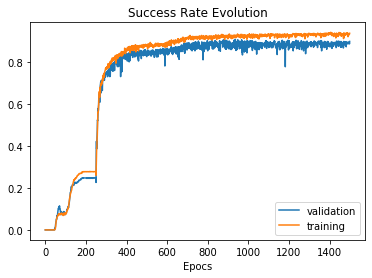

In [14]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

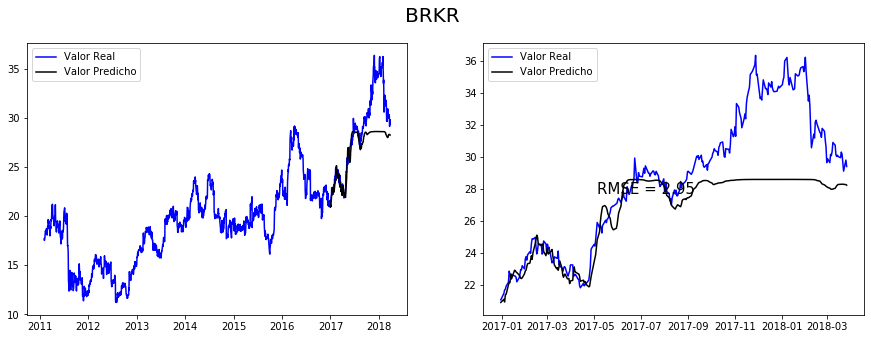

In [15]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [18]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.0005
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 120, 1.0: 100, -1.0: 89})


In [19]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      128633        0      0  29.81  28.2798  -1
Valor Final = 128633.35
Ganancia con margen = 28633.35


In [117]:
print(movimientos_alza)

           presupuesto acciones estado  valor     pred  dif
2016-12-30      100000        0      0  53.58  56.3008  NaN
2017-01-03       44.29     1791      1  55.81  56.4817    1
2017-01-04      101236        0     -1   56.5  56.5125   -1
2017-01-05        1.72     1847      1  54.81  56.4124    1
2017-01-06      100996        0     -1  54.68  56.7544   -1
2017-01-09      100996        0      0  53.22  56.1689   -1
2017-01-10      100996        0      0   52.9  55.5546   -1
2017-01-11      100996        0      0  54.45  54.1805   -1
2017-01-12       27.54     1913      1  52.78  53.7514    1
2017-01-13       27.54     1913      0   53.7  53.8374    1
2017-01-17      103330        0     -1     54  54.3208   -1
2017-01-18       26.06     1918      1  53.86   54.298    1
2017-01-19      102198        0     -1  53.27  54.6275   -1
2017-01-20       22.61     1871      1  54.61  54.5827    1
2017-01-23       22.61     1871      0   54.9  54.8517    1
2017-01-24       22.61     1871      0  

In [20]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      245093        0          4208      0  29.81  28.2798  -1
Valor Final = 119652.39
Ganancia con margen = 19652.39


In [ ]:
print(movimientos_ab)

In [21]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      187013        0          3211      0  29.81  28.2798  -1
Valor Final = 91292.63
Ganancia con margen = -8707.37


In [ ]:
print(movimientos_baja)